In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import xarray as xr
import numpy as np
from glob import glob
from yllib.function import mysom
from yllib.function import myfunc
from yllib.plot import plot_map
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'
%matplotlib inline

Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [2]:
year1   = 1981
year2   = 2020
cold_months  = [10,11,12,1,2,3]
warm_months  = [4,5,6,7,8,9]
mapsize = (8,8)
factor  = ('z')
map_extent = [160,-20+360,25,90]
sig_level = 0.95
disp_order_cold = [1,3,2,0]
disp_order_warm = [2,0,1,3]

## Read MJO index

In [3]:
def read_MJO(year1, year2, rolling=None):
    df = pd.read_csv("../climate_index/MJO_BOM.txt", index_col=0, skiprows=2, skipfooter=0,
         delim_whitespace=True, header=None)
    da = xr.DataArray(df.values[:,-2:],
         coords={"time": pd.date_range("1974-06-01", "2022-03-09", freq="1D"),
                 "var": ["phase", "amplitude"]},
         dims=["time", "var"])
    da = da.where(da!=-99)
    da = da.sel(time=slice(f"{year1}-01-01", f"{year2}-12-31"))
    if rolling is not None: da = da.rolling(time=rolling, center=True, min_periods=2).mean()
    return da
mjo = read_MJO(year1, year2).sel(var="phase")

## Read HGT

In [4]:
data = xr.open_dataset('data/hgt_daily_anomaly_globe.nc')
# select season
data_cold = data.sel(time=data['time.month'].isin(cold_months))['z500']
data_warm = data.sel(time=data['time.month'].isin(warm_months))['z500']

In [5]:
bmu_cold = xr.open_dataset(f"som/kmean_cold_z_{mapsize[0]}x{mapsize[1]}.nc")['bmu']
bmu_warm = xr.open_dataset(f"som/kmean_warm_z_{mapsize[0]}x{mapsize[1]}.nc")['bmu']
bmu_cold.coords['time'] = data_cold.time
bmu_warm.coords['time'] = data_warm.time

In [6]:
bmu_cold.time

<xarray.DataArray 'time' (time: 7290)>
array(['1981-01-01T00:00:00.000000000', '1981-01-02T00:00:00.000000000',
       '1981-01-03T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
    dayofyear  (time) int64 ...
Attributes:
    standard_name:  time
    axis:           T

In [7]:
def bmu_permutation(bmu, season):
    np.random.seed(1024)
    bmu_pmt = np.array([bmu.data[np.random.permutation(len(bmu))] for i in range(1000)])
    bmu_pmt = xr.DataArray(bmu_pmt,
        dims=["seed", "time"],
        coords=[np.arange(1000), bmu.time])
    print(bmu_pmt)
    bmu_pmt.to_netcdf(f"som/bmu_pmt_{season}.nc")
    return bmu_pmt
bmu_pmt_cold = bmu_permutation(bmu_cold, 'cold')
bmu_pmt_warm = bmu_permutation(bmu_warm, 'warm')

<xarray.DataArray (seed: 1000, time: 7290)>
array([[1., 3., 3., ..., 0., 0., 1.],
       [2., 0., 3., ..., 2., 3., 3.],
       [2., 3., 1., ..., 1., 2., 0.],
       ...,
       [1., 0., 2., ..., 2., 2., 0.],
       [3., 2., 0., ..., 3., 1., 3.],
       [0., 3., 0., ..., 0., 2., 3.]])
Coordinates:
  * seed     (seed) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
<xarray.DataArray (seed: 1000, time: 7320)>
array([[1., 0., 0., ..., 0., 0., 3.],
       [1., 0., 3., ..., 3., 3., 2.],
       [0., 3., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 3., ..., 1., 0., 2.],
       [3., 3., 1., ..., 0., 1., 0.],
       [0., 1., 2., ..., 0., 0., 1.]])
Coordinates:
  * seed     (seed) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) datetime64[ns] 1981-04-01 1981-04-02 ... 2020-09-30


In [8]:
bmu_pmt_cold

<xarray.DataArray (seed: 1000, time: 7290)>
array([[1., 3., 3., ..., 0., 0., 1.],
       [2., 0., 3., ..., 2., 3., 3.],
       [2., 3., 1., ..., 1., 2., 0.],
       ...,
       [1., 0., 2., ..., 2., 2., 0.],
       [3., 2., 0., ..., 3., 1., 3.],
       [0., 3., 0., ..., 0., 2., 3.]])
Coordinates:
  * seed     (seed) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31

In [9]:
def calc_bmu_count(data):
    count = []
    for i in np.arange(4):
        count.append(data.where(data==i).count(dim="time"))
    count = xr.concat(count, dim="bmu")
    count.coords["bmu"] = np.arange(4)
    return count

def create_lag_array(data, max_lead=15):
    lead_time_start = data.time.data
    lead_time_end   = [t + pd.Timedelta(f"{max_lead}D") for t in lead_time_start]
    lead_time       = [pd.Timedelta(f"{i}D") for i in range(0,max_lead+1)]
    data_lead = []
    time = []
    for s, e in zip(lead_time_start, lead_time_end):
        _data = data.sel(time=slice(s, e)).rename({"time":"lead_time"})
        if _data.coords["lead_time"].size <= max_lead: continue
        _data["lead_time"] = lead_time
        data_lead.append(_data)
        time.append(s)
    data_lead = xr.concat(data_lead, dim="time")
    data_lead.coords["time"] = pd.to_datetime(time)
    return data_lead
    
    
def calc_permutation(bmu, bmu_pmt, mjo, season):
    bmu_lead = create_lag_array(bmu, max_lead=15)
    mjo = mjo.sel(time=bmu_lead.time)
    bmu_lead.coords["phase"] = ("time", mjo.data)
    occ = bmu_lead.groupby(bmu_lead["phase"]).apply(calc_bmu_count)

    bmu_pmt_lead = create_lag_array(bmu_pmt, max_lead=15)
    bmu_pmt_lead.coords["phase"] = ("time", mjo.data)
    pmt = bmu_pmt_lead.groupby(bmu_pmt_lead["phase"]).apply(calc_bmu_count)
    return occ, pmt

occ, pmt = calc_permutation(bmu_cold, bmu_pmt_cold, mjo, 'cold')

In [33]:
def plot_ganttchart(data, kw_plot={}):
    if (fig:=kw_plot.get("fig")) is None: fig = plt.figure(figsize=(8,6.4))
    if (ax:=kw_plot.get("ax"))  is None: ax  = plt.axes()
    data = data[-15:]

    import seaborn as sns
    cmap = sns.color_palette("Spectral_r", as_cmap=True)
    cmap.set_under(".8")
    sns.heatmap(data, ax=ax, cbar=False, cmap=cmap, vmin=0, vmax=20)
    for i in range(data.shape[0]+1):
        ax.axhline(i, color='white', lw=2)
    ax.set_yticklabels(np.arange(1,9))
    ax.set_xticks(np.arange(0,15,2))
    ax.set_xticklabels(np.arange(0,15,2))
        
def plotfigure_ganttchart(data, season):
    fig, axs = plt.subplots(2,2, figsize=(8,6))
    plt.subplots_adjust(left=0.10, bottom=0.10, right=0.88, top=0.95, hspace=0.10, wspace=0.10)
    axs = axs.ravel()

    if season=='cold': order = disp_order_cold
    if season=='warm': order = disp_order_warm
    
    for i, bmu in enumerate(order):
            plot_ganttchart(data.sel(bmu=bmu), kw_plot={"fig":fig, "ax":axs[i]})
    cbar_ax = fig.add_axes([.91, .25, .03, .5])
    fig.text(0.05, 0.5, 'MJO phase', ha='center', va='center', rotation=90, fontsize=16)
    fig.text(0.5, 0.02, 'MJO precede time (day)', ha='center', va='center', fontsize=16)
    
    abcd = list('abcd')
    regimes = ['AkR', 'PT', 'ArH', 'ArL']
    for ax, a, regime in zip(axs, abcd, regimes):
        ax.text(0.01, 0.95, f'({a}) {regime}', fontsize=12, ha='left', va='top', transform=ax.transAxes)

    fig.colorbar(axs[0].collections[0], cax=cbar_ax)
    # plt.show()


In [11]:
_, _occ = xr.broadcast(pmt, occ)
pmt = pmt.where(pmt>_occ).count(dim="seed")
pval = pmt / 1000.

occ = occ / occ.sum("phase") * 100.

occ = occ.where(pval<0.05, -1)

occ.coords["lead_time"] = np.array(occ.lead_time/86400/1e9).astype(int)


/tmp/ipykernel_22305/3895526903.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Spectral_r").copy()
  cmap.set_under(".8")
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2ac6b1dc4760>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2ac6b1dc4760> on colorbar
Setting pcolormesh


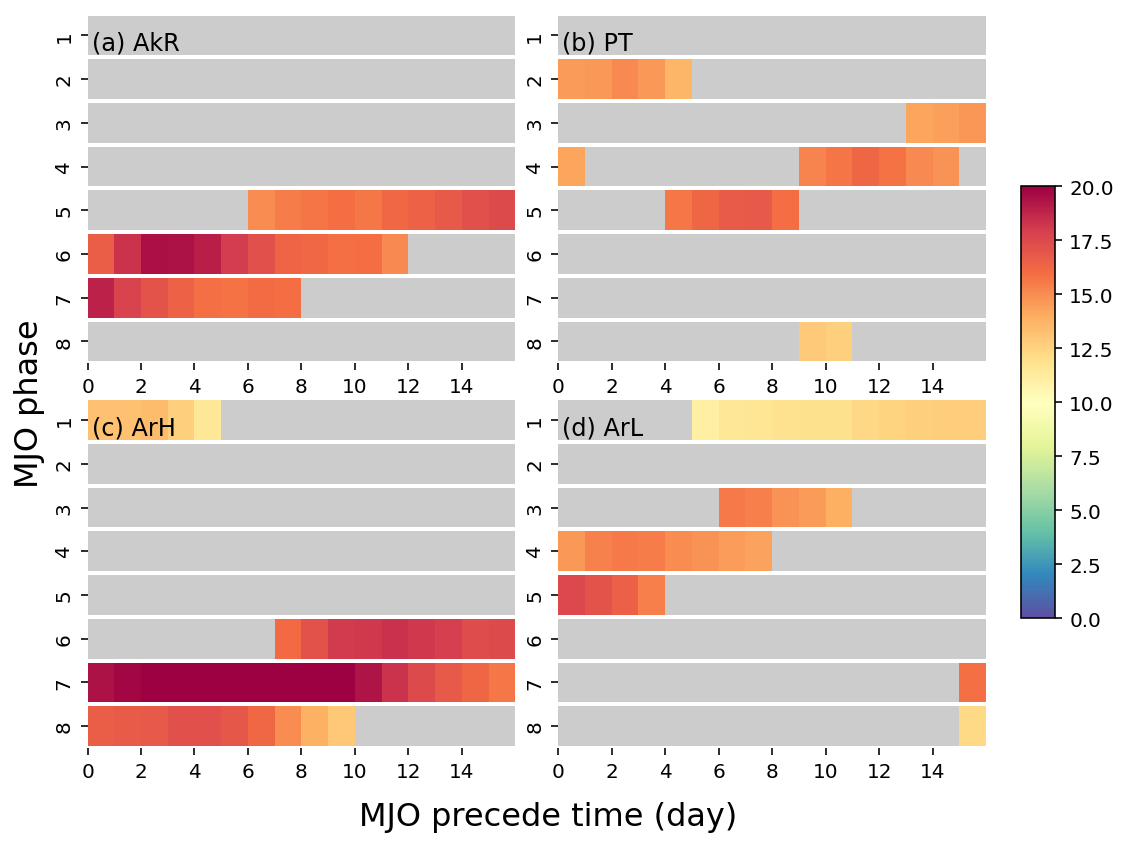

In [37]:
plotfigure_ganttchart(occ, 'cold')